# Standard Imports

In [1]:
#COLAB=False # if running standalone
COLAB=True # if running on colab


import numpy as np
print (np.__version__)
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"


if COLAB:
    !pip install numpy==1.15.4 # to avoid bug loading hdf file "ValueError: cannot set WRITEABLE flag to True of this array"
    print (np.__version__)


1.15.4


In [2]:
if COLAB:
    #### Reading file from Google Drive
    !pip install PyDrive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

In [3]:
# download dataset 
#directory download = drive.CreateFile({'id': '1TuvyEky9lCcc5ybC6nTl5zzkIm8p8AVO'})
#download.GetContentFile("dataWW")

if COLAB:
    #download three file 
    #DRFIXME UPDATE 
    download = drive.CreateFile({'id': '1Pq3zw5PccvdOKPz63vi7NZD6XbzouKAH'})
    download.GetContentFile("atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz")



!ls -lrt

total 880
lrwxr-xr-x  1 rousseau  staff     101 14 jui 09:42 atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz -> /Users/rousseau/Google Drive/GD_ST4Perso/EIParticules/atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz
-rw-r--r--+ 1 rousseau  staff    8337 16 jui 18:17 html_original.html
-rw-r--r--+ 1 rousseau  staff   69533 17 jui 01:30 XGBoost.model
-rw-r--r--@ 1 rousseau  staff  302442 17 jui 02:31 ST4PNT_ML_EI_v1.ipynb
-rw-r--r--+ 1 rousseau  staff     208 17 jui 02:33 higgs_XGBoost.pdf


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython import display
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed

#!pip install pytables # to read hdf5
#!pip install xgboost
#!pip install lightgbm # not sure it loads the .so
#!conda install --yes lightgbm # better run in separate window

In [5]:
# some utilities
from math import sqrt
from math import log


def amsasimov(s,b): # asimov significance
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

 
        
def sensitivity(s,b): # relative error on measurement (smaller is better)
        if s<=0:
            return 3. #arbitrary large value to ease plotting
        try:
            return sqrt(s+b)/s
        except ValueError:
            print ("s=",s,"b=",b)

#
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30, xlabel="", ylabel="Arbitrary units", title="", weights_train=np.array([]), weights_test=np.array([])):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, normed=True, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, normed=True, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.legend(loc='best')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


    



# load signal, background data

In [6]:
fulldata=pd.read_csv("atlas-higgs-challenge-2014-v2-s0_e500000.csv.gz")

In [7]:
fulldata.head(10)
fulldata.columns

Index(['EventId', 'PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_lep_pt',
       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label', 'detailLabel'],
      dtype='object')

In [8]:
fulldata.describe()

,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000
mean,349999.500000,38.714545,-0.013257,-0.011970,46.674137,-0.019437,0.047620,41.701531,-0.008731,209.927965,0.979556,-348.752703,-399.691392,-399.699610,-691.888913,-708.680697,-708.681274,73.165734,0.823212,0.34179,203.420608
std,144337.711634,22.446292,1.213545,1.816473,22.105907,1.264858,1.814938,32.710333,1.811627,126.905884,0.978462,533.104931,489.427615,489.420984,480.144630,453.589257,453.588092,98.390870,0.936718,0.47431,178.763815
min,100000.000000,20.000000,-2.499000,-3.142000,26.000000,-2.508000,-3.142000,0.089000,-3.141000,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.000754,0.00000,0.000000
25%,224999.750000,24.589000,-0.928000,-1.582000,32.385000,-1.012000,-1.516000,21.386000,-1.573000,123.077750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.009362,0.00000,1.000000
50%,349999.500000,31.785000,-0.025000,-0.038000,40.533000,-0.043000,0.092000,34.815000,-0.022000,179.795500,1.000000,38.981000,-1.867500,-2.105000,-999.000000,-999.000000,-999.000000,40.496000,0.582373,0.00000,132.000000
75%,474999.250000,44.955000,0.898000,1.561000,53.379000,0.957000,1.617000,51.929000,1.558000,263.767000,2.000000,75.491000,0.429000,0.494000,33.771250,-2.447000,-2.271000,110.324000,1.199707,1.00000,400.000000
max,599999.000000,764.408000,2.499000,3.142000,701.328000,2.506000,3.142000,2842.617000,3.141000,2190.275000,3.000000,1163.439000,4.499000,3.142000,817.801000,4.500000,3.142000,1860.175000,3.904958,1.00000,400.000000


In [9]:
print ("Normalization is already correct for the full 2012 LHC running. Background and signal.")
# in principle should multiply all the scaleFactor (then weights will vary event by event)
class_weights = (fulldata.query("Label==0").Weight.sum(), fulldata.query("Label==1").Weight.sum()) 
print("total class weights",class_weights)

class_nevents = (len(fulldata.query("Label==0")), len(fulldata.query("Label==1")))
print ("total class number of events",class_nevents)


Normalization is already correct for the full 2012 LHC running. Background and signal.
total class weights (410912.76426711, 693.2443108784654)
total class number of events (329105, 170895)


## Event selection

In [10]:
print (fulldata.shape)
prepdata=fulldata.query("PRI_had_pt>22") # needed for technical reason, when systematics on TES will be applied.
print (prepdata.shape)



(500000, 21)
(439494, 21)


In [11]:
#DR replace dummy -999 by -7, for nicer plots
prepdata.replace(-999,-7,inplace=True)
prepdata.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2
1,100001,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-7.000,-7.00,-7.000,46.226,1.114509,0.0,400
2,100002,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-7.000,-7.00,-7.000,44.251,1.171295,0.0,400
3,100003,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,-0.000,2.717621,0.0,400
4,100004,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,0.000,3.116281,0.0,400


In [12]:
#hide label in separate vector
#WARNING : there should be no selection nor shuffling later on !
target = prepdata["Label"]
del prepdata["Label"]

#hide weight in separate vector
weights = prepdata["Weight"]
del prepdata["Weight"]

#remove unnecessary variable (save in separate DF just in case)
eventid = prepdata["EventId"]
del prepdata["EventId"]

detaillabel = prepdata["detailLabel"]
del prepdata["detailLabel"]


In [13]:
# this isfor simplicity of the exercise only keep some features
# if want to copy some columns
#data=prepdata[['PRI_had_pt', 'PRI_had_eta', 'PRI_had_phi', 'PRI_lep_pt',
#       'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet',
#       'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta',
#       'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
#       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']]
#keep everything
data=prepdata.copy()
print (data.shape)
data.head()




(439494, 17)


,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-7.000,-7.00,-7.000,46.226
2,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-7.000,-7.00,-7.000,44.251
3,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,-0.000
4,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,0.000


(439494, 17)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


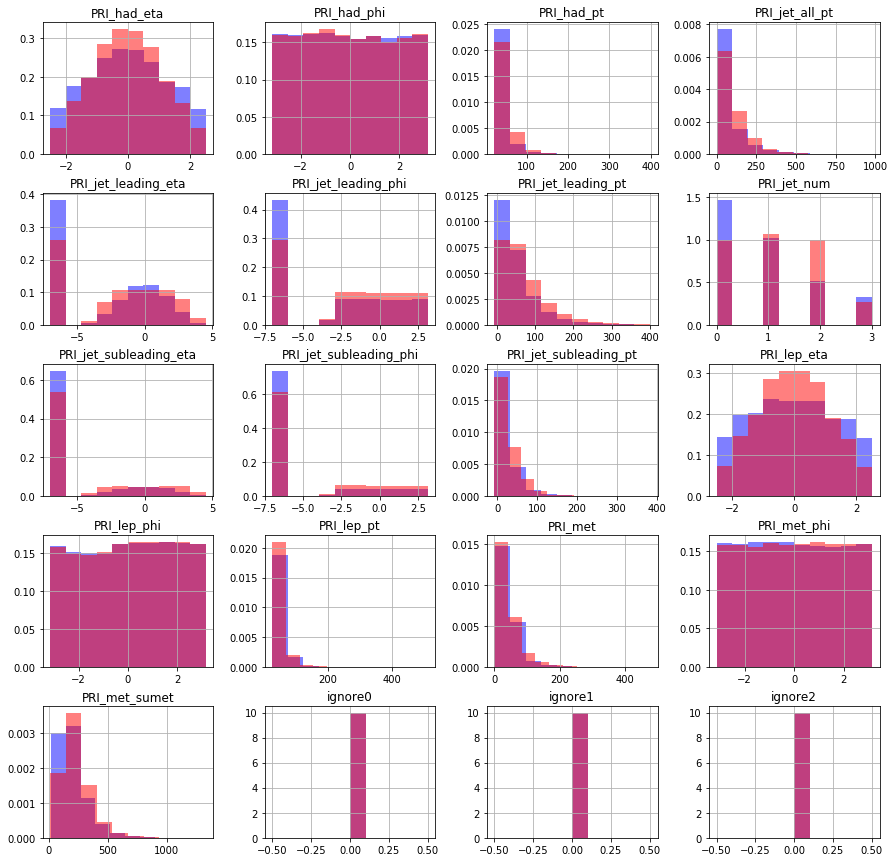

(439494, 17)


In [14]:
#InteractiveShell.ast_node_interactivity="none" #not too much printout

# plot dataset separately
#plt.figure()
#data[Label==0].hist(figsize=(15,12),color='b')
#data[Label==1].hist(figsize=(15,12),color='r')
#plt.show()

print (data.shape)

#all in one plot
nx=4 # number of plot on x axis
ny=5 # number of plot on y axis
fix,axs=plt.subplots(ny,nx,figsize=(15,15))
# note that target is an external array, while PRI_had_pt is a column
# remove some outliers for nicer looking plots
rangestring="PRI_had_pt<400 and PRI_jet_all_pt<1000 and PRI_jet_leading_pt<400 and PRI_jet_subleading_pt<500 and PRI_met <500 "
ndummy=nx*ny-data.shape[1]

#add dummy columns so that the number of colums equal number of plots
for i in range(ndummy):
    data["ignore"+str(i)]=0.
    
    
data[target==0].query(rangestring).hist(ax=axs,alpha=0.5,normed=1,color="b") # signal is blue
data[target==1].query(rangestring).hist(ax=axs,alpha=0.5,normed=1,color="r") # background is red
plt.show()

#immediately delete the stupid columns
for i in range(ndummy):
    del data["ignore"+str(i)]

    
print (data.shape)



# Feature engineering

WP FE This is the place to introduce new features (one might want to plot them as above).

In [15]:
#by convention derived features are prefixed by DER
data["DER_had_lep_delta_phi"]=np.abs(np.mod(data["PRI_had_phi"]-data["PRI_lep_phi"]+3*np.pi,2*np.pi)-np.pi)

print (data.shape)
data.head()



(439494, 18)


,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,DER_had_lep_delta_phi
0,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,2.795000
1,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-7.000,-7.00,-7.000,46.226,3.114000
2,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-7.000,-7.00,-7.000,44.251,3.138185
3,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,-0.000,3.110000
4,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-7.000,-7.000,-7.000,-7.000,-7.00,-7.000,0.000,2.483185


## Transformation of the features

In [16]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # fraction of sample used for training
X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size,random_state=0)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)





#scale to mean 0 and variance 1
scaler = StandardScaler()
#scaler.fit(data)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_train == i] *= 1/(1-train_size) # increase test weight to compensate for sampling
    
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())



    


(329620, 18)
(329620,)
(329620,)
(109874, 18)
(109874,)
(109874,)
class_weights_train: (248097.00347413393, 496.1939854107483)
Test : total weight bkg 328574.5408111478
Test : total weight sig 658.4045637541767
Train : total weight bkg 248097.00347413393
Train : total weight sig 248097.00347413393


# Testing BDT

In [17]:
np.random.seed(31415) # set the random seed

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
xgb = XGBClassifier(tree_method="hist")
#xgb = XGBClassifier(tree_method="hist",max_depth=12) # HPO, check on the web for other parameters
# not a bad idea to check for bugs without hist


starting_time = time.time( )
xgb.fit(X_train, y_train.values, sample_weight=weights_train.values)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_xgb = xgb.predict_proba(X_test)[:,1]
y_pred_xgb = y_pred_xgb.ravel()
y_pred_train_xgb = xgb.predict_proba(X_train)[:,1].ravel()
auc_test_xgb = roc_auc_score(y_true=y_test, y_score=y_pred_xgb)
print("auc test:",auc_test_xgb)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,))

int_pred_test_sig_xgb = [weights_test[(y_test ==1) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_xgb = [weights_test[(y_test ==0) & (y_pred_xgb > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_xgb = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]
vsensitivity_xgb = [sensitivity(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_xgb,int_pred_test_bkg_xgb)]


significance_xgb = max(vamsasimov_xgb)
sensitivity_xgb = min(vsensitivity_xgb)
print ("sensitivity:",sensitivity_xgb)
Z = significance_xgb
print("Z:",Z)
# To save model
xgb.save_model("XGBoost.model")

Training time: 5.7224602699279785
auc test: 0.804392092509481
auc train: 0.8076641338183401
sensitivity: 0.4240817648214591
Z: 2.375345793711337


## Some nice plots 

In [18]:
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('higgs_XGBoost.pdf')

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:59: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same re

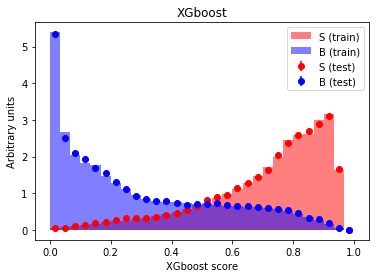

In [19]:

compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, xlabel="XGboost score", title="XGboost", weights_train=weights_train.values, weights_test=weights_test.values)
#plt.savefig(new_dir + "/Score_BDT_XGBoost_Hist.pdf")
#pdf.savefig()
plt.show()


### Histograms

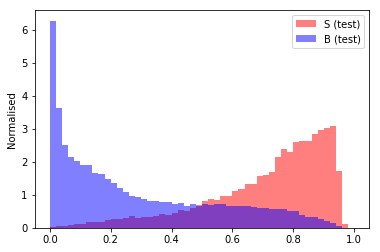

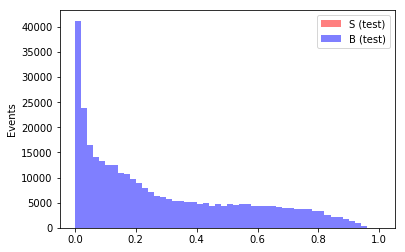

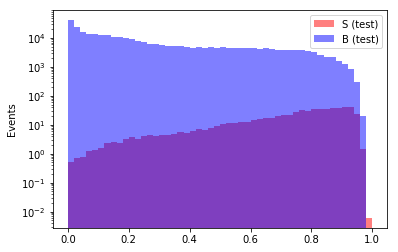

In [20]:
htests=np.histogram(y_pred_xgb[y_test == 1],
                 range=(0,1), bins=50,
                 density=False,weights=weights_test.values[y_test==1]) 
htestb=np.histogram(y_pred_xgb[y_test == 0],
                 range=(0,1), bins=50,
                 density=False,weights=weights_test.values[y_test==0]) 

# compute array of middle of bins (asssume same for signal and background)
scorebin=htests[1] # this is the edge of all bins
scorex=htests[1][:-1] # this is the left edge of all bins
scorex=scorex+(scorex[1]-scorex[0])/2. # this is the middle of all bins


# normalised plot
plt.hist(scorex, scorebin, weights=htests[0],label='S (test)',color='r',density=True,alpha=0.5)
plt.hist(scorex, scorebin, weights=htestb[0],label='B (test)',color='b',density=True,alpha=0.5)
plt.xlabel("")
plt.ylabel("Normalised")
plt.legend(loc='best')
plt.show()


# expected events plot
plt.hist(scorex, scorebin, weights=htests[0],label='S (test)',color='r',density=False,alpha=0.5)
plt.hist(scorex, scorebin, weights=htestb[0],label='B (test)',color='b',density=False,alpha=0.5)
plt.xlabel("")
plt.ylabel("Events")
plt.legend(loc='best')
plt.show()

# expected events plot, log scale


plt.hist(scorex, scorebin, weights=htests[0],label='S (test)',color='r',density=False,log=True,alpha=0.5)
plt.hist(scorex, scorebin, weights=htestb[0],label='B (test)',color='b',density=False,log=True,alpha=0.5)
plt.xlabel("")
plt.ylabel("Events")
plt.legend(loc='best')
plt.show()



### Cumulative Histograms
Now we are going to do a counting experiment. Our signal region is above a threshold to be optimised.
To be able to adjust the threshold we'll work with cumulative histogram, integrating the signal and background component from the right.

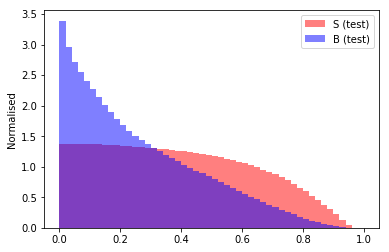

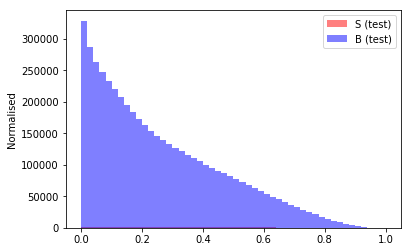

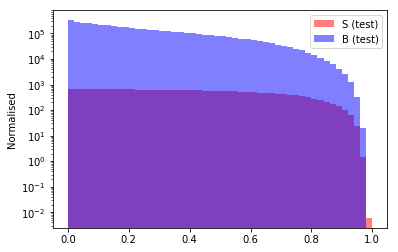

In [21]:
#np.cumsum integrates from the left np.flip flips the array on input and output
hcumtests=np.flip(np.cumsum(np.flip(htests[0]))) 
hcumtestb=np.flip(np.cumsum(np.flip(htestb[0]))) 


# normalised
plt.hist(scorex, scorebin, weights=hcumtests,label='S (test)',color='r',density=True,alpha=0.5)
plt.hist(scorex, scorebin, weights=hcumtestb,label='B (test)',color='b',density=True,alpha=0.5)
plt.xlabel("")
plt.ylabel("Normalised")
plt.legend(loc='best')
plt.show()

# expected events 
plt.hist(scorex, scorebin, weights=hcumtests,label='S (test)',color='r',density=False,alpha=0.5)
plt.hist(scorex, scorebin, weights=hcumtestb,label='B (test)',color='b',density=False,alpha=0.5)
plt.xlabel("")
plt.ylabel("Normalised")
plt.legend(loc='best')
plt.show()

# expected events plot log scale
plt.hist(scorex, scorebin, weights=hcumtests,label='S (test)',color='r',density=False,log=True,alpha=0.5)
plt.hist(scorex, scorebin, weights=hcumtestb,label='B (test)',color='b',density=False,log=True,alpha=0.5)
plt.xlabel("")
plt.ylabel("Normalised")
plt.legend(loc='best')
plt.show()

### ROC Curve "by hand"

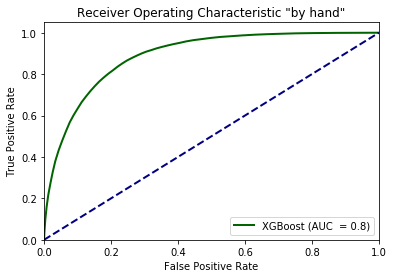

In [22]:
#efficiencies
effis=hcumtests/np.max(hcumtests)
effib=hcumtestb/np.max(hcumtestb)

lw=2
plt.plot(effib,effis, color='darkgreen',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic "by hand"')
plt.legend(loc="lower right")
plt.show()





### Significance

In [23]:
def npamsasimov(s,b): # asimov significance
        aux=np.sqrt(2*((s+b)*np.log(1+s/b)-s))
        aux[np.isinf(aux)]=0 # set infinite to 0 
        return aux


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


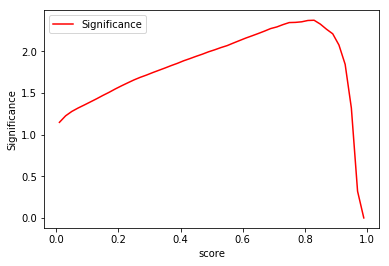

In [24]:
vamsasimov=npamsasimov(hcumtests,hcumtestb)
# expected events plot log scale


plt.plot(scorex, vamsasimov,label='Significance',color='r')
plt.xlabel("score")
plt.ylabel("Significance")
plt.legend(loc='upper left')
plt.show()

### Sensitivity and threshold determination
Determine the sensitivity. WP BDT : THE THRESHOLD SHOULD BE DETERMINED ON TRAINING SET, THEN APPLIED ON TEST SET.

In [25]:
def npsensitivity(s,b): # asimov significance
        aux=np.sqrt(s+b)/s
        return aux

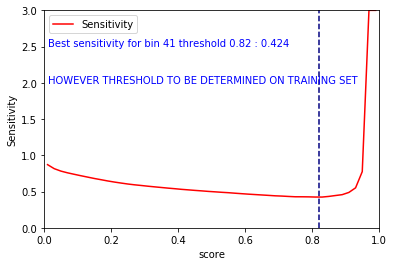

In [26]:
vsensitivity=np.clip(npsensitivity(hcumtests,hcumtestb),0.,3.)  # clip large values

# find position of optimum
iscoremin=np.argmin(vsensitivity)
mess="Best sensitivity for bin "+str(iscoremin)+" threshold "+ str(scorebin[iscoremin])+ " : "+str(np.round(vsensitivity[iscoremin],3))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 3.0])
plt.plot([scorebin[iscoremin], scorebin[iscoremin]], [0, 3], color='navy',  linestyle='--')


plt.text(0.01,2.5,mess,color='b')

plt.text(0.01,2.,"HOWEVER THRESHOLD TO BE DETERMINED ON TRAINING SET",color='b')


plt.plot(scorex,vsensitivity,label='Sensitivity',color='r')
plt.xlabel("score")
plt.ylabel("Sensitivity")
plt.legend(loc='upper left')
plt.show()

### WP NN : implement Neural Net like in TD NN 2

### WP STAT : replace sensitivity by proper Log Maximum Likelihood fit
Observed events : Asimov dataset htests+htestb. Fit with Poisson of expectation mu*htests+htestb . mu is the measurement, which should give 1 if we observe the signal we expect. The uncertainty on mu is the sensitivity we are looking for. See PP TD for example of LML fit.




### WP SYST : evaluate systematics error
Use distort() to generate new dataset distorted by Nuisance Parameters. Evaluate first the systematic error on mu with (distort(s+b)-(s+b))/(s+b) at the threshold (to be reoptimised). Handover to WP Stat group distorted Asimov dataset, which they will fit, yielding this time a mu different than 1. 
Recommended value for Nuisance Parameters :
 * TES : Tau Energy Scale 1.03
 * Tnorm : T background scaling factor 2.
 * JES : Jet energy scale 1.05
 * SOFTMET : Soft Missing Transverse energy 5. GeV

In [27]:
# this should rather be in a utility class
import copy
class V4:
    """
    A simple 4-vector class to ease calculation
    """
    px=0
    py=0
    pz=0
    e=0
    def __init__(self,apx=0., apy=0., apz=0., ae=0.):
        """
        Constructor with 4 coordinates
        """
        self.px = apx
        self.py = apy
        self.pz = apz
        self.e = ae
        if self.e + 1e-3 < self.p():
            raise ValueError("Energy is too small! Energy: {}, p: {}".format(self.e, self.p()))

    def copy(self):
        return copy.deepcopy(self)
    
    def p2(self):
        return self.px**2 + self.py**2 + self.pz**2
    
    def p(self):
        return np.sqrt(self.p2())
    
    def pt2(self):
        return self.px**2 + self.py**2
    
    def pt(self):
        return np.sqrt(self.pt2())
    
    def m(self):
        return np.sqrt( np.abs( self.e**2 - self.p2() ) ) # abs is needed for protection
    
    def eta(self):
        return np.arcsinh( self.pz/self.pt() )
    
    def phi(self):
        return np.arctan2(self.py, self.px)
    
    def deltaPhi(self, v):
        """delta phi with another v"""
        return (self.phi() - v.phi() + 3*np.pi) % (2*np.pi) - np.pi
    
    def deltaEta(self,v):
        """delta eta with another v"""
        return self.eta()-v.eta()
    
    def deltaR(self,v):
        """delta R with another v"""
        return np.sqrt(self.deltaPhi(v)**2+self.deltaEta(v)**2 )

    def eWithM(self,m=0.):
        """recompute e given m"""
        return np.sqrt(self.p2()+m**2)

    # FIXME this gives ugly prints with 1D-arrays
    def __str__(self):
        return "PxPyPzE( %s,%s,%s,%s)<=>PtEtaPhiM( %s,%s,%s,%s) " % (self.px, self.py,self.pz,self.e,self.pt(),self.eta(),self.phi(),self.m())

    def scale(self,factor=1.): # scale
        """Apply a simple scaling"""
        self.px *= factor
        self.py *= factor
        self.pz *= factor
        self.e = np.abs( factor*self.e )
    
    def scaleFixedM(self,factor=1.): 
        """Scale (keeping mass unchanged)"""
        m = self.m()
        self.px *= factor
        self.py *= factor
        self.pz *= factor
        self.e = self.eWithM(m)
    
    def setPtEtaPhiM(self, pt=0., eta=0., phi=0., m=0):
        """Re-initialize with : pt, eta, phi and m"""
        self.px = pt*np.cos(phi)
        self.py = pt*np.sin(phi)
        self.pz = pt*np.sinh(eta)
        self.e = self.eWithM(m)
    
    def sum(self, v):
        """Add another V4 into self"""
        self.px += v.px
        self.py += v.py
        self.pz += v.pz
        self.e += v.e
    
    def __iadd__(self, other):
        """Add another V4 into self"""
        try:
            self.px += other.px
            self.py += other.py
            self.pz += other.pz
            self.e += other.e
        except AttributeError: 
            # If 'other' is not V4 like object then return special NotImplemented error
            return NotImplemented
        return self
    
    def __add__(self, other):
        """Add 2 V4 vectors : v3 = v1 + v2 = v1.__add__(v2)"""
        acopy = self.copy()
        try:
            acopy.px += other.px
            acopy.py += other.py
            acopy.pz += other.pz
            acopy.e += other.e
        except AttributeError: 
            # If 'other' is not V4 like object then return special NotImplemented error
            return NotImplemented
        return acopy


In [28]:
def distort(data_orig, TES=1., TNORM=1., JES=1., SOFTMET=0., missing_value=-999.0):
    """
    Manipulate dataset according to nuisance parameters
    WARNING : All PRI columns should be there as well as Label and Weight
              ALL COMPUTATION OF DERIVED FEATURES SHOULD BE REDONE FROM THE OUTPUT !!!
              Selection PRI_had_pt >22 should be done AFTER distort

    Args
    ----
        data_orig: the dataset should be a pandas.DataFrame like object.
        TES : scaling of hadronic tau energy :  PRI_had_pt *= TES, and MET is updated
        TNORM : T background (detailLabel=300) weight is scaled by TNORM
        JES : scaling of jet energy scale  : XXX_jet_pt *= JES, and MET is updated
        SOFTMET : a random term of energy log gauss SOFTMET, and randomised asimuth angle is added to the MET
        missing_value : (default=-7.0) the value used to code missing value. 
            This is not used to find missing values but to write them in feature column that have some.


    Return : data : modified dataframe


    Output : Round up to 3 decimals.

    """
    data=data_orig.copy() # do not touch input
 
    if SOFTMET>0.:
        # add to vmet a vector of norm SOFTMET*np.random.lognorm(0.,1.) and azimuth angle uniform
        print ("distort() does not implement yet SOFTMET ! Abort.")
        raise Exception

    # scale tau energy scale
    data["PRI_had_pt"] *= TES 

    # first built 4-vectors
    vtau = V4() # tau 4-vector
    vtau.setPtEtaPhiM(data["PRI_had_pt"], data["PRI_had_eta"], data["PRI_had_phi"], 0.8) # tau mass 0.8 like in original

    vlep = V4() # lepton 4-vector
    vlep.setPtEtaPhiM(data["PRI_lep_pt"], data["PRI_lep_eta"], data["PRI_lep_phi"], 0.) # lep mass 0 (either 0.106 or 0.0005 but info is lost)

    vmet = V4() # met 4-vector
    vmet.setPtEtaPhiM(data["PRI_met"], 0., data["PRI_met_phi"], 0.) # met mass zero,

    # fix MET according to tau pt change
    vtauDeltaMinus = vtau.copy()
    vtauDeltaMinus.scaleFixedM( (1.-TES)/TES )
    vmet += vtauDeltaMinus

    
    # first jet if it exists
    data.PRI_jet_leading_pt*=JES
    data.PRI_jet_leading_pt=data.PRI_jet_leading_pt.where( data.PRI_jet_num > 0, other=missing_value )
    
    vj1 = V4()
    vj1.setPtEtaPhiM(data["PRI_jet_leading_pt"].where( data["PRI_jet_num"] > 0, other=0 ),
                         data["PRI_jet_leading_eta"].where( data["PRI_jet_num"] > 0, other=0 ),
                         data["PRI_jet_leading_phi"].where( data["PRI_jet_num"] > 0, other=0 ),
                         0.) # zero mass
    #print ("vj1")
    #print(vj1)
    # fix MET according to leading jet  pt change
    vj1DeltaMinus = vj1.copy()
    #print ("vj1DeltaMinus")
    #print(vj1DeltaMinus)






    vj1DeltaMinus.scaleFixedM( (1.-JES)/JES )
    #print ("vj1DeltaMinus again")
    #print(vj1DeltaMinus)


    #print("vmet before")
    #print (vmet)



    vmet += vj1DeltaMinus
    #print ("vmet after")
    #print(vmet)



    
    # second jet if it exists
    data.PRI_jet_subleading_pt*=JES
    data.PRI_jet_subleading_pt=data.PRI_jet_leading_pt.where( data.PRI_jet_num > 1, other=missing_value )
    

    vj2=V4()
    vj2.setPtEtaPhiM(data["PRI_jet_subleading_pt"].where( data["PRI_jet_num"] > 1, other=0 ),
                     data["PRI_jet_subleading_eta"].where( data["PRI_jet_num"] > 1, other=0 ),
                     data["PRI_jet_subleading_phi"].where( data["PRI_jet_num"] > 1, other=0 ),
                     0.) # zero mass


    # fix MET according to subleading jet  pt change
    vj2DeltaMinus = vj2.copy()
    vj2DeltaMinus.scaleFixedM( (1.-JES)/JES )
    vmet += vj2DeltaMinus

    # sum pt jet if at least one jet
    data.PRI_jet_all_pt*=JES
    data.PRI_jet_all_pt=data.PRI_jet_all_pt.where( data.PRI_jet_num > 0, other=missing_value )
    # not enough info to fix MET for third jet or more. Should be rare

    
    
    # reset met : z component and mass to 0
    vmet.pz = 0.
    vmet.e = vmet.eWithM(0.)

    #print ("vmet final")
    #print(vmet)

    
    data["PRI_met"] = vmet.pt()
    data["PRI_met_phi"] = vmet.phi()

    #scale Weight for T  
    data.Weight=data.Weight.where (data.detailLabel!=300, other=data.Weight*TNORM) 
        
    
    # Fix precision to 3 decimals
    DECIMALS = 3

    data["PRI_had_pt"] = data["PRI_had_pt"].round(decimals=DECIMALS)
    data["PRI_had_eta"] = data["PRI_had_eta"].round(decimals=DECIMALS)
    data["PRI_had_phi"] = data["PRI_had_phi"].round(decimals=DECIMALS)
    data["PRI_lep_pt"] = data["PRI_lep_pt"].round(decimals=DECIMALS)
    data["PRI_lep_eta"] = data["PRI_lep_eta"].round(decimals=DECIMALS)
    data["PRI_lep_phi"] = data["PRI_lep_phi"].round(decimals=DECIMALS)
    data["PRI_met"] = data["PRI_met"].round(decimals=DECIMALS)
    data["PRI_met_phi"] = data["PRI_met_phi"].round(decimals=DECIMALS)
    data["PRI_met_sumet"] = data["PRI_met_sumet"].round(decimals=DECIMALS)
    data["PRI_jet_leading_pt"] = data["PRI_jet_leading_pt"].round(decimals=DECIMALS)
    data["PRI_jet_leading_eta"] = data["PRI_jet_leading_eta"].round(decimals=DECIMALS)
    data["PRI_jet_leading_phi"] = data["PRI_jet_leading_phi"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_pt"] = data["PRI_jet_subleading_pt"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_eta"] = data["PRI_jet_subleading_eta"].round(decimals=DECIMALS)
    data["PRI_jet_subleading_phi"] = data["PRI_jet_subleading_phi"].round(decimals=DECIMALS)
    data["PRI_jet_all_pt"] = data["PRI_jet_all_pt"].round(decimals=DECIMALS)

    return data

In [29]:
disdata=distort(fulldata,TES=1.03)

In [30]:
fulldata.head()

,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.001333,1.0,2
1,100001,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400
2,100002,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400
3,100003,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,2.717621,0.0,400
4,100004,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,3.116281,0.0,400


In [31]:
disdata.head()

,EventId,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,detailLabel
0,100000,33.617,1.017,0.381,51.626,2.273,-2.414,16.060,-0.314,258.733,2,67.435,2.150,0.444,67.435,1.24,-2.475,113.497,0.001333,1.0,2
1,100001,43.274,2.039,-3.011,36.918,0.501,0.103,44.141,-1.891,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,1.114509,0.0,400
2,100002,33.119,-0.705,-2.093,121.409,-0.953,1.052,53.323,-2.188,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,1.171295,0.0,400
3,100003,23.326,-1.655,0.010,53.321,-0.522,-3.100,30.403,0.061,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-999.000,2.717621,0.0,400
4,100004,29.055,-2.197,-2.231,29.774,0.798,1.569,2.677,-0.557,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-999.000,3.116281,0.0,400
